# Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import PIL # pillow - image processing
import tensorflow as tf
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib
import matplotlib.pyplot as plt

tf.random.set_seed(123)

In [20]:
import os
#os.chdir(r"D:\PhD Classes (Big_files)\Neural Networks\Neural Networks\Project\2nd_dataset_image\Cropped_1Channel_Mask")
#os.chdir(r'/home/said.mejia/Projects/Deep_Learning/Dataset')
print(os.path.dirname(os.getcwd()))

/glade/scratch/hgamarro/Deep_learning/HG_space/notebooks


In [21]:
import sys
sys.path
sys.path.append(r'../../src/models/')

In [22]:
from image_segmentation.keras_segmentation.models.unet import vgg_unet
from image_segmentation.keras_segmentation.models.unet import resnet50_unet
from image_segmentation.keras_segmentation.models.segnet import vgg_segnet
from image_segmentation.keras_segmentation.models.segnet import resnet50_segnet

# PLEASE READ LINE BELLOW

### Before use this notebook, please create a folder in githubfolder/models/Save_Models or run the following commented line

In [23]:
folder_name = 'Save_Models'
# os.mkdir(r'../../models/'f'{folder_name}')

# Reading Images and Masks

In [24]:
reading_images = sorted(glob.glob(r'../../data/processed/Balanced_80/test/Images/*.png'))
reading_masks = sorted(glob.glob(r'../../data/processed/Balanced_80/test/Masks/*.png'))


In [25]:
img_num = 226
img = PIL.Image.open(reading_images[img_num], 'r')
mask = PIL.Image.open(reading_masks[img_num], 'r')

In [26]:
print(reading_images[img_num])
print(reading_masks[img_num])

../../data/processed/Balanced_80/test/Images/atch_14_Image_23_Tile_13.png
../../data/processed/Balanced_80/test/Masks/atch_14_Image_23_Tile_13.png


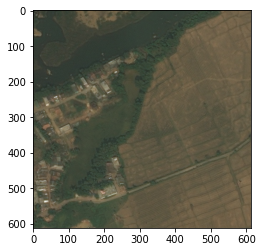

In [27]:
plt.imshow(np.asarray(img))

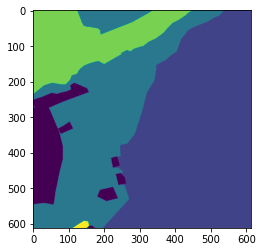

In [28]:
plt.imshow(np.asarray(mask))

# GPU

In [29]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

# mirrored_strategy = tf.distribute.MirroredStrategy()

1 Physical GPUs, 1 Logical GPU


# Plot Function

In [30]:
import matplotlib
from matplotlib.colors import ListedColormap


def plot_label_plot(mask, labels, col_dict, ax, fig):
    # Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
    # col_dict={1:"blue",
    #           2:"red",
    #           3:"orange",
    #           4:"green",
    #           5:"yellow",
    #           6:"purple",
    #           7:"grey"}
    
    # We create a colormar from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
    
    # Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
    # labels = np.array(['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'])
    len_lab = len(labels)
    
    
    # prepare normalizer
    ## Prepare bins for the normalizer
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    #print(norm_bins)
    ## Make normalizer and formatter
    norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
    
    # Plot our figure
#     fig,ax = plt.subplots()
    im = ax.imshow(mask, cmap=cm, norm=norm)
    
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    cb = fig.colorbar(im, format=fmt, ticks=tickz)
    return ax, fig

In [31]:
def plot_label(mask, labels, col_dict, ax):
    # Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
    # col_dict={1:"blue",
    #           2:"red",
    #           3:"orange",
    #           4:"green",
    #           5:"yellow",
    #           6:"purple",
    #           7:"grey"}
    
    # We create a colormar from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
    
    # Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
    # labels = np.array(['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'])
    len_lab = len(labels)
    
    
    # prepare normalizer
    ## Prepare bins for the normalizer
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    #print(norm_bins)
    ## Make normalizer and formatter
    norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
    
    # Plot our figure
#     fig,ax = plt.subplots()
    im = ax.imshow(mask, cmap=cm, norm=norm)
    
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    #cb = fig.colorbar(im, format=fmt, ticks=tickz)

# History Function

In [32]:
def plot_history(history):
       
    acc = history.history['iou_score']
    val_acc = history.history['val_iou_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

## Ploting the class labels

In [33]:
labels = pd.read_csv('../../data/processed/Balanced_80/class_dict.csv')
classes = list(labels['name'])
classes

['unknown',
 'urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land']

In [34]:
labels = classes
col_dict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 
           4: 'yellow', 5: 'purple', 6: 'grey', }
col_dict

{0: 'blue',
 1: 'red',
 2: 'orange',
 3: 'green',
 4: 'yellow',
 5: 'purple',
 6: 'grey'}

# Paths

In [35]:
weight_path= ['Model_Best_Weights_vgg_unet.hdf5',
             'Model_Best_Weights_resnet50_unet.hdf5',
             'Model_Best_Weights_vgg_segnet.hdf5',
             'Model_Best_Weights_resnet50_segnet.hdf5']
save_path= ['Model_Save_Model_vgg_unet.h5',
             'Model_Save_Model_resnet50_unet.h5',
             'Model_Save_Model_vgg_segnet.h5',
             'Model_Save_Model_resnet50_segnet.h5']
image_path= ['Model_vgg_unet.png',
             'Model_resnet50_unet.png',
             'Model_vgg_segnet.png',
             'Model_resnet50_segnet.png']

# 0. VGG_UNET

In [40]:
i = 0

In [41]:
# with mirrored_strategy.scope():
#     model_0 = vgg_unet(n_classes=7 , input_height=512, input_width=512)
# #model_0.summary()

model_0 = vgg_unet(n_classes=7 , input_height=512, input_width=512)

In [49]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                    mode='max',
                filepath= '../../models/'f'{folder_name}''/' + weight_path[i],
                        save_best_only=True,
                        verbose=1), 
    EarlyStopping(monitor='val_iou_score',
                  patience=10,
                  restore_best_weights=True,
                  mode='max')
]

In [50]:
from datetime import datetime
start = datetime.now()
model_0_hist = model_0.train(
    input_height = 612,
    input_width = 612,
    verify_dataset = False,
    train_images =  "../../data/processed/Balanced_80/train/Images/",
    train_annotations = "../../data/processed/Balanced_80/train/Masks/",
    validate= True,
    val_images =  "../../data/processed/Balanced_80/val/Images/",
    val_annotations = "../../data/processed/Balanced_80/val/Masks/",
    epochs=100,
    callbacks = callbacks
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/100
512/512 [==============================] - ETA: 0s - loss: 0.5133 - iou_score: 0.4414 - f1-score: 0.5920
Epoch 00001: val_iou_score improved from -inf to 0.52818, saving model to ../../models/Save_Models/Model_Best_Weights_vgg_unet.hdf5
512/512 [==============================] - 177s 346ms/step - loss: 0.5133 - iou_score: 0.4414 - f1-score: 0.5920 - val_loss: 0.4050 - val_iou_score: 0.5282 - val_f1-score: 0.6683
Epoch 2/100
512/512 [==============================] - ETA: 0s - loss: 0.5097 - iou_score: 0.4454 - f1-score: 0.5946
Epoch 00002: val_iou_score improved from 0.52818 to 0.54358, saving model to ../../models/Save_Models/Model_Best_Weights_vgg_unet.hdf5
512/512 [==============================] - 183s 358ms/step - loss: 0.5097 - iou_score: 0.4454 - f1-score: 0.5946 - val_loss: 0.3834 - val_iou_score: 0.5436 - val_f1-score: 0.6806
Epoch 3/100
512/512 [==============================] - ETA: 0s - loss: 0.4901 - iou_score: 0.4609 - f1-score: 0.6107
Epoch 00003: val_iou_sco

## Saving the model

In [76]:
model_0.save('../../models/'f'{folder_name}''/' + save_path[i])

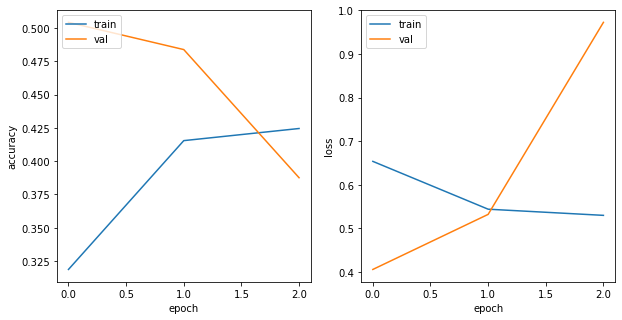

In [27]:
plot_history(model_0_hist)

In [56]:
out = model_0.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + image_path[i]
)

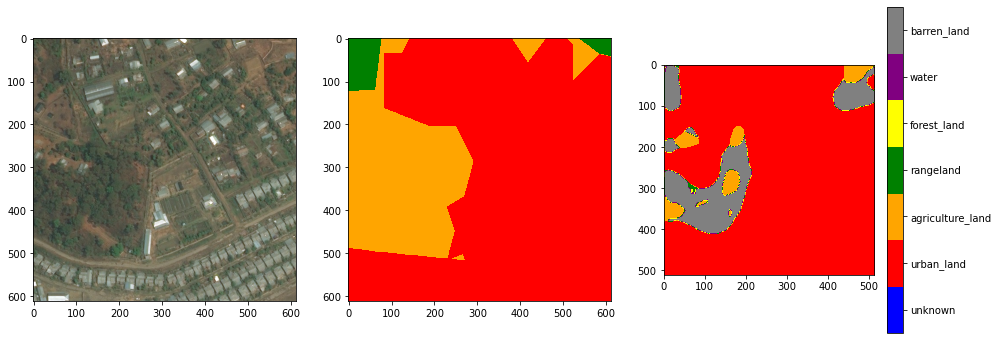

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
# fig.subplots_adjust(hspace=0.1)
axes[0].imshow(np.asarray(img))
axes[1] = plot_label(np.asarray(mask), labels,col_dict, axes[1])
axes[2] = plot_label_plot(np.asarray(out), labels,col_dict, axes[2], fig)

# 1. RESNET_UNET

In [18]:
i = 1

In [19]:
model_1 = resnet50_unet(n_classes=7 , input_height=512, input_width=512)
#model_1.summary()

94658560/94653016 [==============================] - 1s 0us/step


In [20]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                    mode='max',
                filepath= '../../models/'f'{folder_name}''/' + weight_path[i],
                        save_best_only=True,
                        verbose=1), 
    EarlyStopping(monitor='val_iou_score',
                  patience=10,
                  restore_best_weights=True,
                  mode='max')
]

In [21]:
from datetime import datetime
start = datetime.now()
model_1_hist = model_1.train(
    input_height = 612,
    input_width = 612,
    verify_dataset = False,
    train_images =  "../../data/processed/Balanced_80/train/Images/",
    train_annotations = "../../data/processed/Balanced_80/train/Masks/",
    validate= True,
    val_images =  "../../data/processed/Balanced_80/val/Images/",
    val_annotations = "../../data/processed/Balanced_80/val/Masks/",
    epochs=100, 
    callbacks = callbacks
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/100
512/512 [==============================] - ETA: 0s - loss: 0.6979 - iou_score: 0.2625 - f1-score: 0.3916
Epoch 00001: val_iou_score improved from -inf to 0.48032, saving model to ../../models/Save_Models/Model_Best_Weights_resnet50_unet.hdf5
512/512 [==============================] - 199s 389ms/step - loss: 0.6979 - iou_score: 0.2625 - f1-score: 0.3916 - val_loss: 0.4548 - val_iou_score: 0.4803 - val_f1-score: 0.6218
Epoch 2/100
512/512 [==============================] - ETA: 0s - loss: 0.5966 - iou_score: 0.3622 - f1-score: 0.5101
Epoch 00002: val_iou_score improved from 0.48032 to 0.53273, saving model to ../../models/Save_Models/Model_Best_Weights_resnet50_unet.hdf5
512/512 [==============================] - 180s 352ms/step - loss: 0.5966 - iou_score: 0.3622 - f1-score: 0.5101 - val_loss: 0.4063 - val_iou_score: 0.5327 - val_f1-score: 0.6720
Epoch 3/100
512/512 [==============================] - ETA: 0s - loss: 0.5289 - iou_score: 0.4215 - f1-score: 0.5713
Epoch 00003: v

## Saving the model

In [22]:
model_1.save('../../models/'f'{folder_name}''/' + save_path[i])

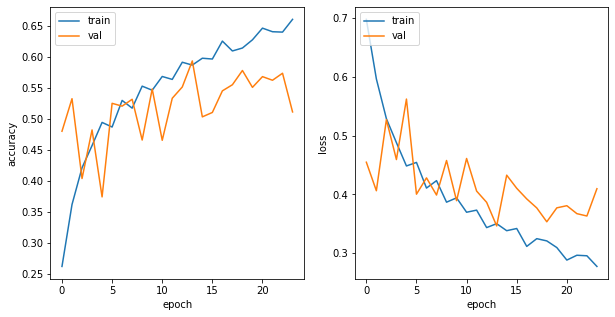

In [23]:
plot_history(model_1_hist)

In [24]:
out = model_1.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + image_path[i]
)

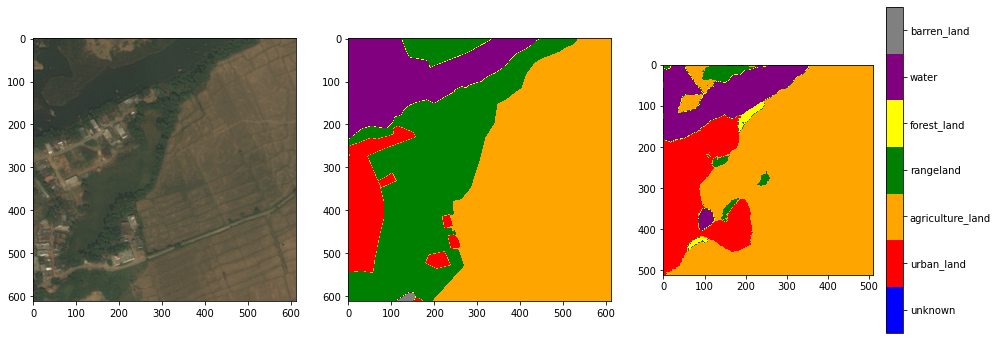

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
# fig.subplots_adjust(hspace=0.1)
axes[0].imshow(np.asarray(img))
axes[1] = plot_label(np.asarray(mask), labels,col_dict, axes[1])
axes[2] = plot_label_plot(np.asarray(out), labels,col_dict, axes[2], fig)

# 2. VGG_SEGNET

In [6]:
tf.keras.backend.clear_session()

In [7]:
i = 2

In [28]:
model_2 = vgg_segnet(n_classes=7 , input_height=512, input_width=512)
#model_2.summary()

In [29]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                    mode='max',
                filepath= '../../models/'f'{folder_name}''/' + weight_path[i],
                        save_best_only=True,
                        verbose=1), 
    EarlyStopping(monitor='val_iou_score',
                  patience=10,
                  restore_best_weights=True,
                  mode='max')
]

In [30]:
from datetime import datetime
start = datetime.now()
model_2_hist = model_2.train(
    input_height = 612,
    input_width = 612,
    verify_dataset = False,
    train_images =  "../../data/processed/Balanced_80/train/Images/",
    train_annotations = "../../data/processed/Balanced_80/train/Masks/",
    validate= True,
    val_images =  "../../data/processed/Balanced_80/val/Images/",
    val_annotations = "../../data/processed/Balanced_80/val/Masks/",
    epochs=100, 
    callbacks = callbacks
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/100
512/512 [==============================] - ETA: 0s - loss: 0.6356 - iou_score: 0.3307 - f1-score: 0.4720
Epoch 00001: val_iou_score improved from -inf to 0.48506, saving model to ../../models/Save_Models/Model_Best_Weights_vgg_segnet.hdf5
512/512 [==============================] - 172s 336ms/step - loss: 0.6356 - iou_score: 0.3307 - f1-score: 0.4720 - val_loss: 0.4556 - val_iou_score: 0.4851 - val_f1-score: 0.6280
Epoch 2/100
512/512 [==============================] - ETA: 0s - loss: 0.5335 - iou_score: 0.4248 - f1-score: 0.5759
Epoch 00002: val_iou_score improved from 0.48506 to 0.54459, saving model to ../../models/Save_Models/Model_Best_Weights_vgg_segnet.hdf5
512/512 [==============================] - 169s 330ms/step - loss: 0.5335 - iou_score: 0.4248 - f1-score: 0.5759 - val_loss: 0.3869 - val_iou_score: 0.5446 - val_f1-score: 0.6807
Epoch 3/100
512/512 [==============================] - ETA: 0s - loss: 0.5176 - iou_score: 0.4363 - f1-score: 0.5888
Epoch 00003: val_iou

## Saving the model

In [31]:
model_2.save('../../models/'f'{folder_name}''/' + save_path[i])

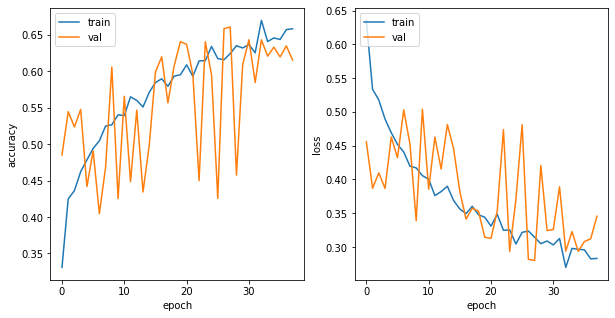

In [32]:
plot_history(model_2_hist)

In [33]:
out = model_2.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + image_path[i]
)

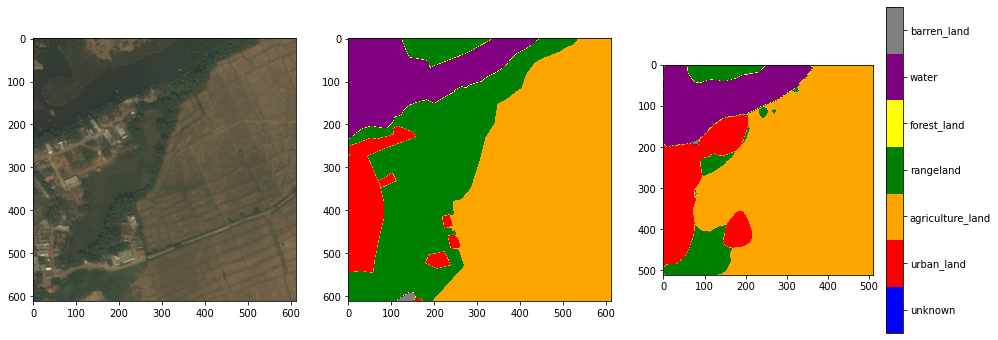

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
# fig.subplots_adjust(hspace=0.1)
axes[0].imshow(np.asarray(img))
axes[1] = plot_label(np.asarray(mask), labels,col_dict, axes[1])
axes[2] = plot_label_plot(np.asarray(out), labels,col_dict, axes[2], fig)

# 3. RESNET_SEGNET

In [36]:
tf.keras.backend.clear_session()

In [37]:
i = 3

In [38]:
model_3 = resnet50_segnet(n_classes=7 , input_height=512, input_width=512)
#model_3.summary()

In [39]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                    mode='max',
                filepath= '../../models/'f'{folder_name}''/' + weight_path[i],
                        save_best_only=True,
                        verbose=1), 
    EarlyStopping(monitor='val_iou_score',
                  patience=10,
                  restore_best_weights=True,
                  mode='max')
]

In [40]:
from datetime import datetime
start = datetime.now()
model_3_hist = model_3.train(
    input_height = 612,
    input_width = 612,
    verify_dataset = False,
    train_images =  "../../data/processed/Balanced_80/train/Images/",
    train_annotations = "../../data/processed/Balanced_80/train/Masks/",
    validate= True,
    val_images =  "../../data/processed/Balanced_80/val/Images/",
    val_annotations = "../../data/processed/Balanced_80/val/Masks/",
    epochs=100, 
    callbacks = callbacks
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/100
512/512 [==============================] - ETA: 0s - loss: 0.6102 - iou_score: 0.3493 - f1-score: 0.4958
Epoch 00001: val_iou_score improved from -inf to 0.44689, saving model to ../../models/Save_Models/Model_Best_Weights_resnet50_segnet.hdf5
512/512 [==============================] - 170s 333ms/step - loss: 0.6102 - iou_score: 0.3493 - f1-score: 0.4958 - val_loss: 0.5051 - val_iou_score: 0.4469 - val_f1-score: 0.5889
Epoch 2/100
512/512 [==============================] - ETA: 0s - loss: 0.5275 - iou_score: 0.4231 - f1-score: 0.5739
Epoch 00002: val_iou_score improved from 0.44689 to 0.54706, saving model to ../../models/Save_Models/Model_Best_Weights_resnet50_segnet.hdf5
512/512 [==============================] - 171s 334ms/step - loss: 0.5275 - iou_score: 0.4231 - f1-score: 0.5739 - val_loss: 0.4019 - val_iou_score: 0.5471 - val_f1-score: 0.6825
Epoch 3/100
512/512 [==============================] - ETA: 0s - loss: 0.4624 - iou_score: 0.4822 - f1-score: 0.6298
Epoch 0000

## Saving the model

In [41]:
model_3.save('../../models/'f'{folder_name}''/' + save_path[i])

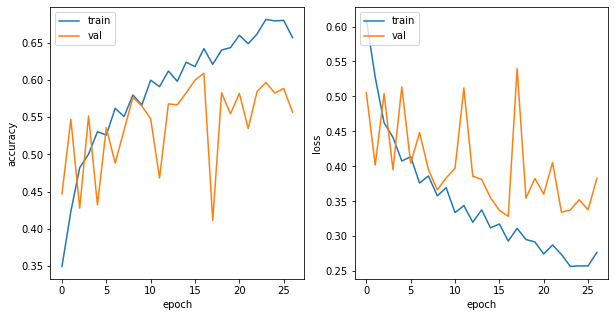

In [42]:
plot_history(model_3_hist)

In [43]:
out = model_3.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + image_path[i]
)

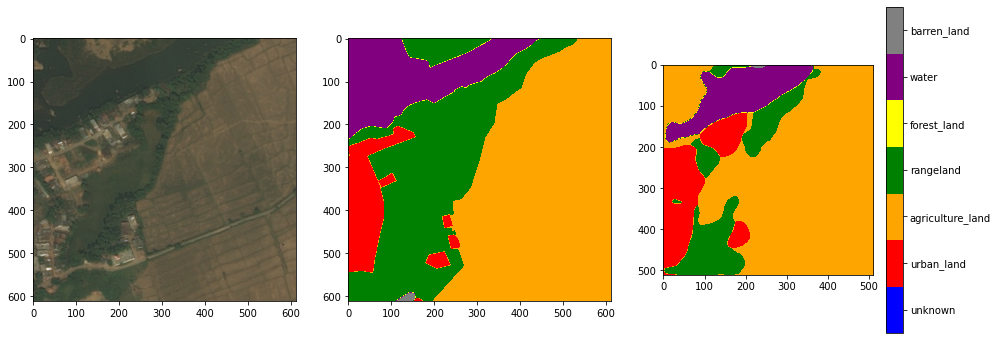

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
# fig.subplots_adjust(hspace=0.1)
axes[0].imshow(np.asarray(img))
axes[1] = plot_label(np.asarray(mask), labels,col_dict, axes[1])
axes[2] = plot_label_plot(np.asarray(out), labels,col_dict, axes[2], fig)